In [1]:
import math
import numpy as np
from matplotlib import pyplot as plt
from pandas_datareader import data as pdr
import yfinance as yf
(
    yf
    .pdr_override()
)

import datetime
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [2]:
stocks =\
    ["AAPL", # Note that FB has been changed to META
     "AMZN",
     "GOOGL",
     "NVDA"]

def extract_sp(stocks, start, end):
    def data(ticker):
        return(pdr.get_data_yahoo(ticker,
                                  start = start,
                                  end = end)
              )
    FAANG_Stock = map(data, stocks)
    return(pd.concat(FAANG_Stock,
                     keys = stocks,
                     names = ["Company", "Date"]
                    )
          )

FAANG =\
    extract_sp(stocks,
               datetime.datetime(2022, 4, 17),
               datetime.datetime(2024, 4, 17)
              )

Daily_Closing_Price =\
(
FAANG[["Close"]]
    .reset_index()
    .pivot(index = "Date",
           columns = "Company",
           values = "Close")
)

Daily_Closing_Price

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Company,AAPL,AMZN,GOOGL,NVDA
Date,,,,
2022-04-18,165.070007,152.785004,127.676498,217.830002
2022-04-19,167.399994,158.115494,130.009003,221.979996
2022-04-20,167.229996,153.998001,128.039993,214.820007
2022-04-21,166.419998,148.296005,124.814499,201.830002
2022-04-22,161.789993,144.350006,119.635498,195.149994
...,...,...,...,...
2024-04-10,167.779999,185.949997,156.139999,870.390015
2024-04-11,175.039993,189.050003,159.410004,906.159973
2024-04-12,176.550003,186.130005,157.729996,881.859985


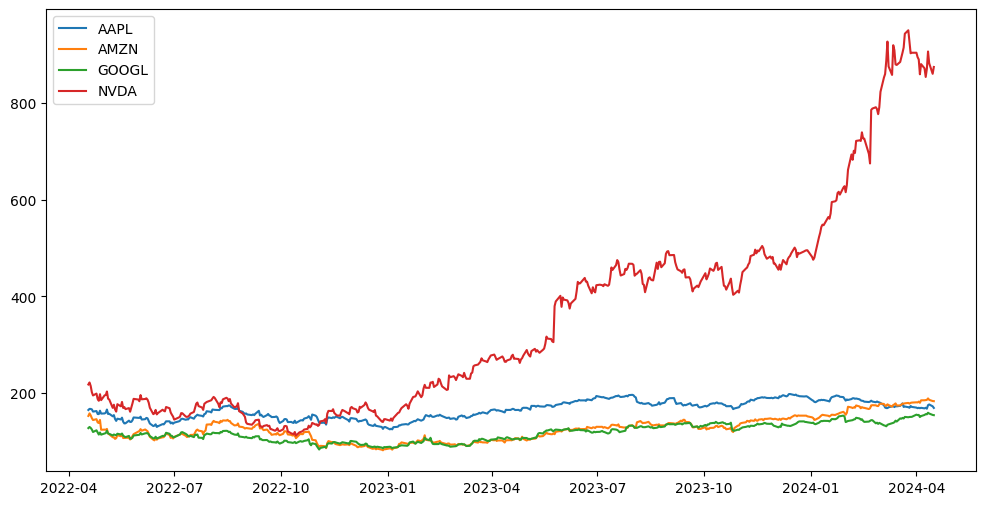

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(Daily_Closing_Price, label = Daily_Closing_Price.columns)
plt.legend()
plt.show()

In [4]:
Daily_Closing_Price.corr()

Company,AAPL,AMZN,GOOGL,NVDA
Company,,,,
AAPL,1.000000,0.698157,0.795029,0.693960
AMZN,0.698157,1.000000,0.908312,0.843364
GOOGL,0.795029,0.908312,1.000000,0.851536
NVDA,0.693960,0.843364,0.851536,1.000000


In [5]:
def mcSpread(payoff, S1, S2, T, r, q1, q2, vol1, vol2, rho, nPaths, nT):
    np.random.seed(0)
    sum, hsquare, C = 0, 0, np.identity(2)
    C[0, 1] = C[1, 0] = rho
    L = np.linalg.cholesky(C)
    for i in range(nPaths):
        brownians = np.zeros((2, nT))
        dt = T / nT
        stdev = math.sqrt(dt)
        # generate brownian increments
        for j in range(2):
            brownians[j] = np.random.normal(0, stdev, nT)
        brownians = np.matmul(L, brownians)
        x1, x2 = math.log(S1), math.log(S2)
        for j in range(nT):
            # simulate asset 1
            a = (r-q1-0.5*vol1*vol1) * dt # drift for asset 1
            b = brownians[0, j] * vol1 # diffusion term for asset 1
            x1 += a + b  # update state variable
            # simulate asset 2
            a = (r-q2-0.5*vol2*vol1) * dt # drift for asset 1
            b = brownians[1, j] * vol2 # diffusion term for asset 1
            x2 += a + b  # update state variable
        h = payoff(math.exp(x1), math.exp(x2))
        sum += h
        hsquare += h*h
    pv = math.exp(-r * T) * sum / nPaths
    se = math.sqrt((hsquare/nPaths - (sum/nPaths)*(sum/nPaths))/nPaths)
    return pv, se

In [6]:
nPaths = 1000
nT = 7
T = 7/12
S1 = Daily_Closing_Price['AAPL'][-1]
S2 = Daily_Closing_Price['AMZN'][-1]
S3 = Daily_Closing_Price['GOOGL'][-1]
S4 = Daily_Closing_Price['NVDA'][-1]
r = 0.04
q1 = q2 = q3 = q4 = 0
vol1 = 0.2
vol2 = 0.2
vol3 = 0.2
vol4 = 0.2
#np.random.seed(0)
sum, hsquare = 0, 0
C = Daily_Closing_Price.corr().values
L = np.linalg.cholesky(C)
x1_all = np.zeros((nPaths, nT+1))
x2_all = np.zeros((nPaths, nT+1))
x3_all = np.zeros((nPaths, nT+1))
x4_all = np.zeros((nPaths, nT+1))

for i in range(nPaths):
    brownians = np.zeros((4, nT))
    dt = T / nT
    stdev = math.sqrt(dt)
    # generate brownian increments
    for j in range(4):
        brownians[j] = np.random.normal(0, stdev, nT)
    brownians = np.matmul(L, brownians)
    x1, x2, x3, x4 = [],[],[],[]
    x1.append(math.log(S1))
    x2.append(math.log(S2))
    x3.append(math.log(S3))
    x4.append(math.log(S4))
    
    for j in range(nT):
        # simulate asset 1
        a = (r-q1-0.5*vol1*vol1) * dt # drift for asset 1
        b = brownians[0, j] * vol1 # diffusion term for asset 1
        x1.append(a + b)  # update state variable
        # simulate asset 2
        a = (r-q2-0.5*vol2*vol2) * dt # drift for asset 1
        b = brownians[1, j] * vol2 # diffusion term for asset 1
        x2.append(a + b) # update state variable
        # simulate asset 3
        a = (r-q3-0.5*vol3*vol3) * dt # drift for asset 1
        b = brownians[2, j] * vol3 # diffusion term for asset 1
        x3.append(a + b)  # update state variable
        # simulate asset 4
        a = (r-q4-0.5*vol4*vol4) * dt # drift for asset 1
        b = brownians[3, j] * vol4 # diffusion term for asset 1
        x4.append(a + b) # update state variable
        
    x1_all[i]=x1
    x2_all[i]=x2
    x3_all[i]=x3
    x4_all[i]=x4

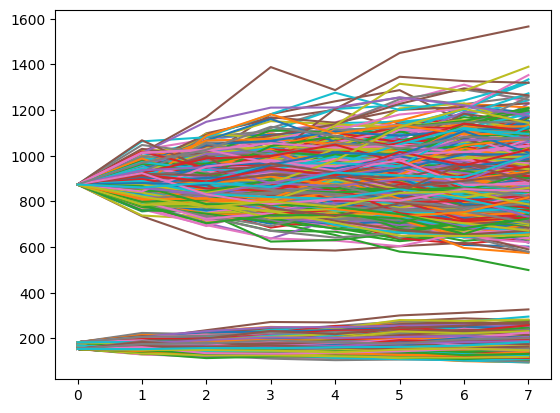

In [13]:
plt.plot(np.exp(x1_all.cumsum(axis=1).T))
plt.plot(np.exp(x2_all.cumsum(axis=1).T))
plt.plot(np.exp(x3_all.cumsum(axis=1).T))
plt.plot(np.exp(x4_all.cumsum(axis=1).T))
plt.show()